In [30]:
# Cell 1
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np


In [31]:
# Cell 2
# Data loading with better parameters
img_height = 180
img_width = 180
batch_size = 32

# CRITICAL FIX: Use different seeds and fresh loading
import random
import time

# Generate a truly random seed each time
random_seed = int(time.time()) % 10000
print(f"Using seed: {random_seed}")

train_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=random_seed,  # Use random seed each time
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=random_seed,  # Same seed to ensure no overlap
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)


Using seed: 3256
Found 2961 files belonging to 6 classes.
Using 2369 files for training.
Using 2369 files for training.
Found 2961 files belonging to 6 classes.
Using 592 files for validation.
Found 2961 files belonging to 6 classes.
Using 592 files for validation.


In [32]:
# Cell 3
# Get class names and setup preprocessing
class_names = train_ds.class_names
print("Classes détectées :", class_names)
print(f"Number of classes: {len(class_names)}")

# Simpler data augmentation to avoid overfitting
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),  # Reduced rotation
    tf.keras.layers.RandomZoom(0.1),
])

# Apply preprocessing - FIXED: Apply augmentation only to training
def preprocess_train(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = data_augmentation(image)
    return image, label

def preprocess_val(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Apply different preprocessing to train and validation
train_ds = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_val, num_parallel_calls=tf.data.AUTOTUNE)

# Performance optimization - FIXED: Remove cache to prevent data leakage
train_ds = train_ds.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


Classes détectées : ['Apple', 'Banana', 'Carrot', 'Coconut', 'Potato', 'Tomato']
Number of classes: 6


In [33]:
# Cell 4
# Fresh model creation - ensure no pre-trained weights
import os

# Delete old model if it exists to prevent weight loading
if os.path.exists("model1.keras"):
    os.remove("model1.keras")
    print("Deleted old model file")

num_classes = len(class_names)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(img_height, img_width, 3)),
    
    # First block
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),
    
    # Second block
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),
    
    # Third block
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),
    
    # Flatten and dense layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile with appropriate learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# CRITICAL: Test initial accuracy - should be around 16% for 6 classes
print("\n" + "="*50)
print("TESTING INITIAL ACCURACY (should be ~16% for random guessing)")
print("="*50)
initial_loss, initial_acc = model.evaluate(val_ds, verbose=1)
print(f"Initial accuracy: {initial_acc*100:.2f}%")
if initial_acc > 0.3:  # If > 30%, something is wrong
    print("⚠️  WARNING: Initial accuracy is too high! Model may have loaded pre-trained weights.")
else:
    print("✅ Initial accuracy looks normal - starting fresh training.")
print("="*50)


Deleted old model file


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │     7,929,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,024,006 (30.61 MB)

 Trainable params: 8,024,006 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

Deleted old model file


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │     7,929,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,024,006 (30.61 MB)

 Trainable params: 8,024,006 (30.61 MB)

 Non-trainable params: 0 (0.00 B)


TESTING INITIAL ACCURACY (should be ~16% for random guessing)
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.0000e+00 - loss: 1.8245
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.0000e+00 - loss: 1.8245
Initial accuracy: 0.00%
✅ Initial accuracy looks normal - starting fresh training.
Initial accuracy: 0.00%
✅ Initial accuracy looks normal - starting fresh training.


In [34]:
# Cell 5
# Training with callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,  # Reduced patience
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,  # Reduced patience
    min_lr=0.0001,
    verbose=1
)

# Train with fewer epochs initially
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,  # Reduced epochs
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 0.6024 - loss: 1.0633 - val_accuracy: 0.8632 - val_loss: 0.2760 - learning_rate: 0.0010
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 0.6024 - loss: 1.0633 - val_accuracy: 0.8632 - val_loss: 0.2760 - learning_rate: 0.0010
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 0.8240 - loss: 0.5806 - val_accuracy: 0.8514 - val_loss: 0.4797 - learning_rate: 0.0010
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 0.8240 - loss: 0.5806 - val_accuracy: 0.8514 - val_loss: 0.4797 - learning_rate: 0.0010
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 0.8485 - loss: 0.4880 - val_accuracy: 0.8497 - val_loss: 0.3101 - learning_rate: 0.0010
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 0.8485 - loss: 0.4880 - val_accuracy: 0.8497 - val_loss: 0.3101 - learning_rate: 0.0010
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8700 - loss: 0.4

In [35]:
# Cell 6
# Save the model
model.save("model1.keras")
print("Model saved successfully!")


Model saved successfully!


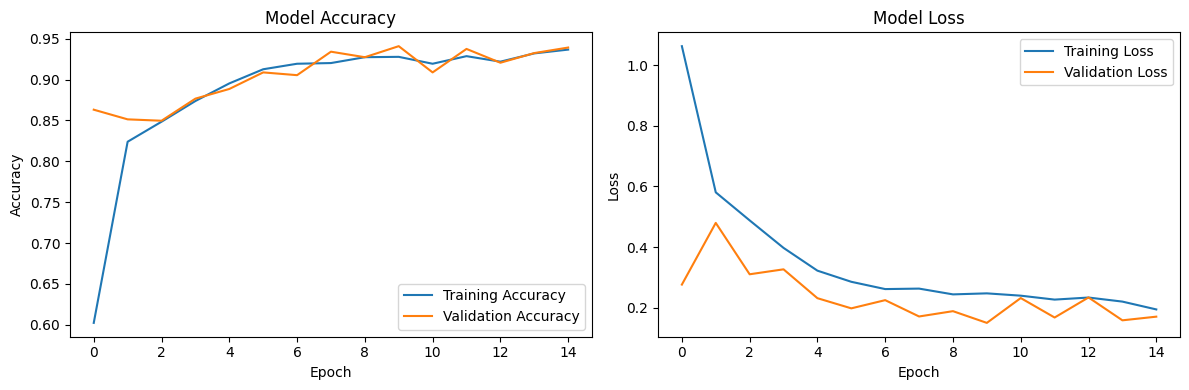

Best validation accuracy: 94.09%


In [36]:
# Cell 7
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Print final validation accuracy
final_val_acc = max(history.history['val_accuracy'])
print(f"Best validation accuracy: {final_val_acc*100:.2f}%")
